# Doc2Vec Test

In [1]:
import gensim
import os
import collections
import smart_open
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

RANDOM_STATE = 41

In [2]:
df = pd.read_csv("../data/data_jobposts_it.csv")
df["text"] = df.jobpost
df["label"] = df.IT
df = df[["text", "label"]]
df.head(5)

,text,label
0,AMERIA Investment Consulting Company\nJOB TITL...,False
1,International Research & Exchanges Board (IREX...,False
2,Caucasus Environmental NGO Network (CENN)\nJOB...,False
3,Manoff Group\nJOB TITLE: BCC Specialist\nPOSI...,False
4,Yerevan Brandy Company\nJOB TITLE: Software D...,True


## Define a Function to Read and Preprocess Text

In [3]:
train, test = train_test_split(df, test_size=0.30, random_state=RANDOM_STATE, stratify=df["label"])

In [4]:
def read_corpus(dataframe, tokens_only=False):
    for row in dataframe.iterrows():
        if tokens_only:
            yield gensim.utils.simple_preprocess(row[1]['text'])
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(row[1]['text']), [row[1]['label']])

In [5]:
train_corpus = list(read_corpus(train))
test_corpus = list(read_corpus(test, tokens_only=True))

In [6]:
train_corpus[:1]

[TaggedDocument(words=['save', 'the', 'children', 'international', 'armenian', 'representative', 'office', 'title', 'driver', 'logistician', 'term', 'full', 'time', 'start', 'date', 'time', 'march', 'location', 'yerevan', 'armenia', 'job', 'description', 'the', 'driver', 'logistician', 'will', 'be', 'fully', 'responsible', 'for', 'the', 'maintenance', 'and', 'technical', 'oversight', 'of', 'the', 'representative', 'office', 'vehicle', 'fleet', 'transport', 'operations', 'and', 'reporting', 'this', 'includes', 'scheduling', 'of', 'vehicles', 'for', 'servicing', 'management', 'of', 'vehicle', 'fleet', 'and', 'coordination', 'of', 'vehicle', 'assignments', 'for', 'staff', 'transportation', 'and', 'supervision', 'of', 'drivers', 'the', 'incumbent', 'will', 'be', 'ultimately', 'responsible', 'for', 'ensuring', 'that', 'all', 'sci', 'personnel', 'and', 'property', 'are', 'transported', 'in', 'the', 'safest', 'manner', 'possible', 'and', 'in', 'strict', 'accordance', 'with', 'relevant', 'agen

In [7]:
len(test_corpus[:1][0])

249

## Training the Model

### Instantiate a Doc2Vec Object¶

In [8]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=2, epochs=40)

### Build a Vocabulary

In [9]:
model.build_vocab(train_corpus)

### Time to Train

If the BLAS library is being used, this should take no more than 3 seconds. If the BLAS library is not being used, this should take no more than 2 minutes, so use BLAS if you value your time.

In [10]:
np.show_config()

blas_mkl_info:
  NOT AVAILABLE
blis_info:
  NOT AVAILABLE
openblas_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
blas_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_mkl_info:
  NOT AVAILABLE
openblas_lapack_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]


In [11]:
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 3min 19s, sys: 2.3 s, total: 3min 21s
Wall time: 1min 13s


### Inferring a Vector

One important thing to note is that you can now infer a vector for any piece of text without having to re-train the model by passing a list of words to the model.infer_vector function. This vector can then be compared with other vectors via cosine similarity.

In [12]:
model.infer_vector(['only', 'you', 'can', 'prevent', 'forest', 'fires'])

array([ 0.11993464,  0.06103383,  0.0358479 , -0.1467592 ,  0.01417663,
        0.05853273,  0.18080038, -0.07603522,  0.19370246,  0.25028706,
       -0.1744133 , -0.10115156,  0.05233283, -0.00788944,  0.01995182,
        0.11607894, -0.08528315, -0.01110276, -0.05080802,  0.07050474,
       -0.03395127, -0.04830793,  0.10094498,  0.12753408, -0.08098111,
       -0.0153179 ,  0.13074286,  0.04588256, -0.08034714,  0.02581976,
       -0.16801327, -0.21571971,  0.10034394, -0.06858094,  0.06212711,
       -0.14616475,  0.07763265,  0.03157115,  0.03727923,  0.12855203,
       -0.02204283,  0.00306406,  0.17649132,  0.04223145,  0.0199463 ,
        0.2230159 ,  0.06578144,  0.02941306,  0.00967784, -0.03317848,
       -0.15309119, -0.16908848,  0.1008231 , -0.02785151,  0.06799634,
        0.07847132, -0.11122034, -0.04517649, -0.04000286,  0.1090109 ,
       -0.19787933, -0.00516194,  0.02461855,  0.13880552,  0.11666964,
        0.04139508, -0.24547438,  0.05404897,  0.07370555, -0.05

## Assessing Model

To assess our new model, we'll first infer new vectors for each document of the training corpus, compare the inferred vectors with the training corpus, and then returning the rank of the document based on self-similarity. Basically, we're pretending as if the training corpus is some new unseen data and then seeing how they compare with the trained model. The expectation is that we've likely overfit our model (i.e., all of the ranks will be less than 2) and so we should be able to find similar documents very easily. Additionally, we'll keep track of the second ranks for a comparison of less similar documents.

In [13]:
doc_id = 0
print('Document ({}): «{}»\n'.format(doc_id, ' '.join(train_corpus[doc_id].words)))
inferred_vector = model.infer_vector(train_corpus[doc_id].words)
print("Inferred Vector: {}".format(inferred_vector))
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('SECOND-MOST', 1), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))

Document (0): «save the children international armenian representative office title driver logistician term full time start date time march location yerevan armenia job description the driver logistician will be fully responsible for the maintenance and technical oversight of the representative office vehicle fleet transport operations and reporting this includes scheduling of vehicles for servicing management of vehicle fleet and coordination of vehicle assignments for staff transportation and supervision of drivers the incumbent will be ultimately responsible for ensuring that all sci personnel and property are transported in the safest manner possible and in strict accordance with relevant agency and donor policy and procedures and local traffic regulations the driver logistician will also be responsible for outsourcing services for office maintenance and repair transportation services for delivery of materials to the projects sites and logistical support to the sci staff job overse

## Testing the Model

Using the same approach above, we'll infer the vector for a randomly chosen test document, and compare the document to our model by eye.

In [14]:
# Pick a random document from the test corpus and infer a vector from the model
doc_id = random.randint(0, len(test_corpus) - 1)
inferred_vector = model.infer_vector(test_corpus[doc_id])
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

# Compare and print the most/median/least similar documents from the train corpus
print('Test Document ({}): «{}»\n'.format(doc_id, ' '.join(test_corpus[doc_id])))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))

Test Document (1349): «general transworld manufacturing company title lawyer legal advisor term long term location yerevan armenia job description the incumbent will perform duties and activities to conduct all the legal affairs related to the company job provide legal advice and guidance to company as well as keep control over all the legal issues affecting its business operations develop strategies for protecting companys interests rights and integrity and the companys business activities conduct legal researches and analyses drafting opinion represent the company and or the company in court carry out case management draft and maintain legal memoranda and day to day legal documentation and their translations as well as manage negotiations involving legal aspects review contracts and their translations for purchases sales and other in coordination with the commercial and financial departments recommend for changes and or improvements monetary control and adherence to internal and stat

In [17]:
filename = "./models/doc2vec_model"
model.save("./models/doc2vec_model")

In [18]:
from gensim.models.doc2vec import Doc2Vec


model = Doc2Vec.load(filename)  # you can continue training with the loaded model!
model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

## Use Doc2Vec with SVM

In [19]:
train_X, train_y = [], []
for corpora in train_corpus:
    train_X.append(model.infer_vector(corpora.words))
    train_y.append(corpora.tags[0])
    
train_X = np.array(train_X)
train_y = np.array(train_y)

In [20]:
test_X = []
for corpora in test_corpus:
    test_X.append(model.infer_vector(corpora))
    
test_X = np.array(test_X)

In [25]:
test_y = test['label']

In [21]:
from sklearn import svm

clf = svm.SVC(gamma=0.001, C=100.)

clf.fit(train_X, train_y)  

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [22]:
predicted_y = clf.predict(test_X)

In [67]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, classification_report

def pretty_print_conf_matrix(y_true, y_pred, 
                             classes,
                             normalize=False,
                             title='Confusion matrix',
                             cmap=plt.cm.Blues):
    """
    Mostly stolen from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

    Normalization changed, classification_report stats added below plot
    """

    cm = confusion_matrix(y_true, y_pred)

    # Configure Confusion Matrix Plot Aesthetics (no text yet) 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

    # Calculate normalized values (so all cells sum to 1) if desired
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(),2) #(axis=1)[:, np.newaxis]

    # Place Numbers as Text on Confusion Matrix Plot
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

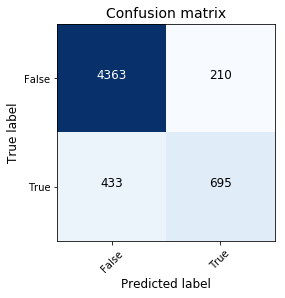

In [68]:
pretty_print_conf_matrix(y_true=test_y, y_pred=predicted_y, classes=["False", "True"])

In [69]:
rpt = classification_report(test_y, predicted_y)
print(rpt)

              precision    recall  f1-score   support

       False       0.91      0.95      0.93      4573
        True       0.77      0.62      0.68      1128

   micro avg       0.89      0.89      0.89      5701
   macro avg       0.84      0.79      0.81      5701
weighted avg       0.88      0.89      0.88      5701

